In [1]:
import networkx as nx
import scipy.stats as sp
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import powerlaw
import mpmath
from itertools import product

In [2]:
from helpful_functions import *

In [3]:
K = ig.Graph.Read_GML('human-disease.gml')

In [4]:
pp =  nx.Graph(K.to_networkx())

#### All Classes:

In [5]:
classes = list(dict(pp.nodes.data('disclass')).values())
print('Classes:')
print()
for c in set(classes):
    print(f'   - {c}')
print()
print('Number of classes:', len(set(classes)))

Classes:

   - Renal
   - Dermatological
   - Connective tissue disorder
   - Cancer
   - Endocrine
   - Immunological
   - Unclassified
   - Metabolic
   - Muscular
   - Developmental
   - Skeletal
   - Nutritional
   - Bone
   - Respiratory
   - Neurological
   - Hematological
   - Ophthamological
   - Gastrointestinal
   - Ear,Nose,Throat
   - Multiple
   - Cardiovascular
   - Psychiatric

Number of classes: 22


#### Number of Nodes per Class:

In [6]:
npn = Counter(classes)
s_npn = dict(sorted(npn.items(), key=lambda x: x[1], reverse=True))
for n, s in s_npn.items():
    print(f"- {n}: {s}")
    
print()
print('Number of Nodes:', len(pp))

- Cancer: 88
- Neurological: 55
- Multiple: 54
- Ophthamological: 39
- Hematological: 34
- Metabolic: 32
- Cardiovascular: 27
- Endocrine: 27
- Immunological: 24
- Skeletal: 23
- Dermatological: 21
- Muscular: 15
- Connective tissue disorder: 15
- Bone: 15
- Unclassified: 9
- Renal: 8
- Psychiatric: 8
- Developmental: 8
- Respiratory: 4
- Gastrointestinal: 4
- Ear,Nose,Throat: 3
- Nutritional: 3

Number of Nodes: 516


## Properties:

### Average Degree

In [7]:
avg_degree(pp)

4.604651162790698

### Average Clustering

In [8]:
nx.average_clustering(pp)

0.6358304997771199

### Assortativity

In [9]:
nx.degree_pearson_correlation_coefficient(pp)

0.06664558386107433

### Diameter

In [10]:
nx.diameter(pp)

15

### Shortest Path

In [11]:
nx.average_shortest_path_length(pp)

6.5089937532926925

### Centralities

In [12]:
deg_centr = nx.degree_centrality(pp)
cl_centr = nx.closeness_centrality(pp)
bet_centr = nx.betweenness_centrality(pp)

#### Degree Vs Closeness

Correlation coefficients - Degree Vs Closeness

Pearson’s: 0.41482353809884986
Spearman's: 0.3261306233207293
Kendall’s: 0.2380531404540927


Text(0.5, 0, 'degree centrality')

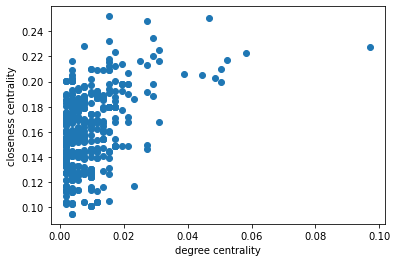

In [13]:
spearman = sp.spearmanr(list(deg_centr.values()),list(cl_centr.values()))[0]
kendal = sp.kendalltau(list(deg_centr.values()),list(cl_centr.values()))[0]
pearson = sp.pearsonr(list(deg_centr.values()),list(cl_centr.values()))[0]
print('Correlation coefficients - Degree Vs Closeness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(deg_centr.values()),list(cl_centr.values()))
plt.ylabel('closeness centrality')
plt.xlabel('degree centrality')

#### Degree Vs Betweenness

Correlation coefficients - Degree Vs Betweenness

Pearson’s: 0.510186582896587
Spearman's: 0.6071015828501782
Kendall’s: 0.5030659638058488


Text(0.5, 0, 'degree centrality')

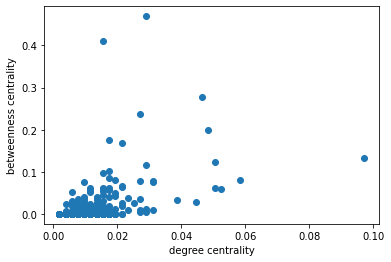

In [14]:
spearman = sp.spearmanr(list(deg_centr.values()),list(bet_centr.values()))[0]
kendal = sp.kendalltau(list(deg_centr.values()),list(bet_centr.values()))[0]
pearson = sp.pearsonr(list(deg_centr.values()),list(bet_centr.values()))[0]
print('Correlation coefficients - Degree Vs Betweenness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(deg_centr.values()),list(bet_centr.values()))
plt.ylabel('betweenness centrality')
plt.xlabel('degree centrality')

#### Closeness Vs Betweenness

Correlation coefficients - Closeness Vs Betweenness

Pearson’s: 0.38422918644035287
Spearman's: 0.29257995969519734
Kendall’s: 0.22714248145921972


Text(0.5, 0, 'closeness centrality')

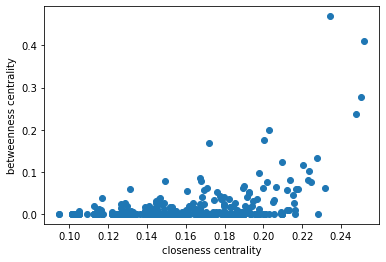

In [15]:
spearman = sp.spearmanr(list(cl_centr.values()),list(bet_centr.values()))[0]
kendal = sp.kendalltau(list(cl_centr.values()),list(bet_centr.values()))[0]
pearson = sp.pearsonr(list(cl_centr.values()),list(bet_centr.values()))[0]
print('Correlation coefficients - Closeness Vs Betweenness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(cl_centr.values()),list(bet_centr.values()))
plt.ylabel('betweenness centrality')
plt.xlabel('closeness centrality')

## Distribution

In [16]:
degs = np.asarray([d for d in dict(pp.degree()).values()])
net_spacing = np.linspace(min(degs),max(degs),len(degs))
avg_deg = avg_degree(pp)
pp_pw = powerlaw.Fit(degs)

Calculating best minimal value for power law fit


<function matplotlib.pyplot.show(close=None, block=None)>

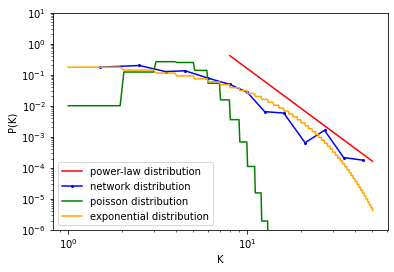

In [17]:
pp_pw.power_law.plot_pdf(color='r')
powerlaw.plot_pdf(degs,color='b',marker='o', markersize=2)
plt.plot(net_spacing, poisson_pdf(net_spacing, avg_deg), color='g')
plt.plot(net_spacing, exp_pdf(net_spacing, avg_deg), color='orange')
plt.legend(['power-law distribution', 'network distribution', 'poisson distribution', 'exponential distribution'])
plt.ylabel('P(K)')
plt.xlabel('K')
ax = plt.gca()
ax.set_ylim([0.000001, 10])
plt.show

In [18]:
pp_pw.distribution_compare('power_law', 'exponential')[0]

13.502940815078812

The network has a power-law distribution

## Plots

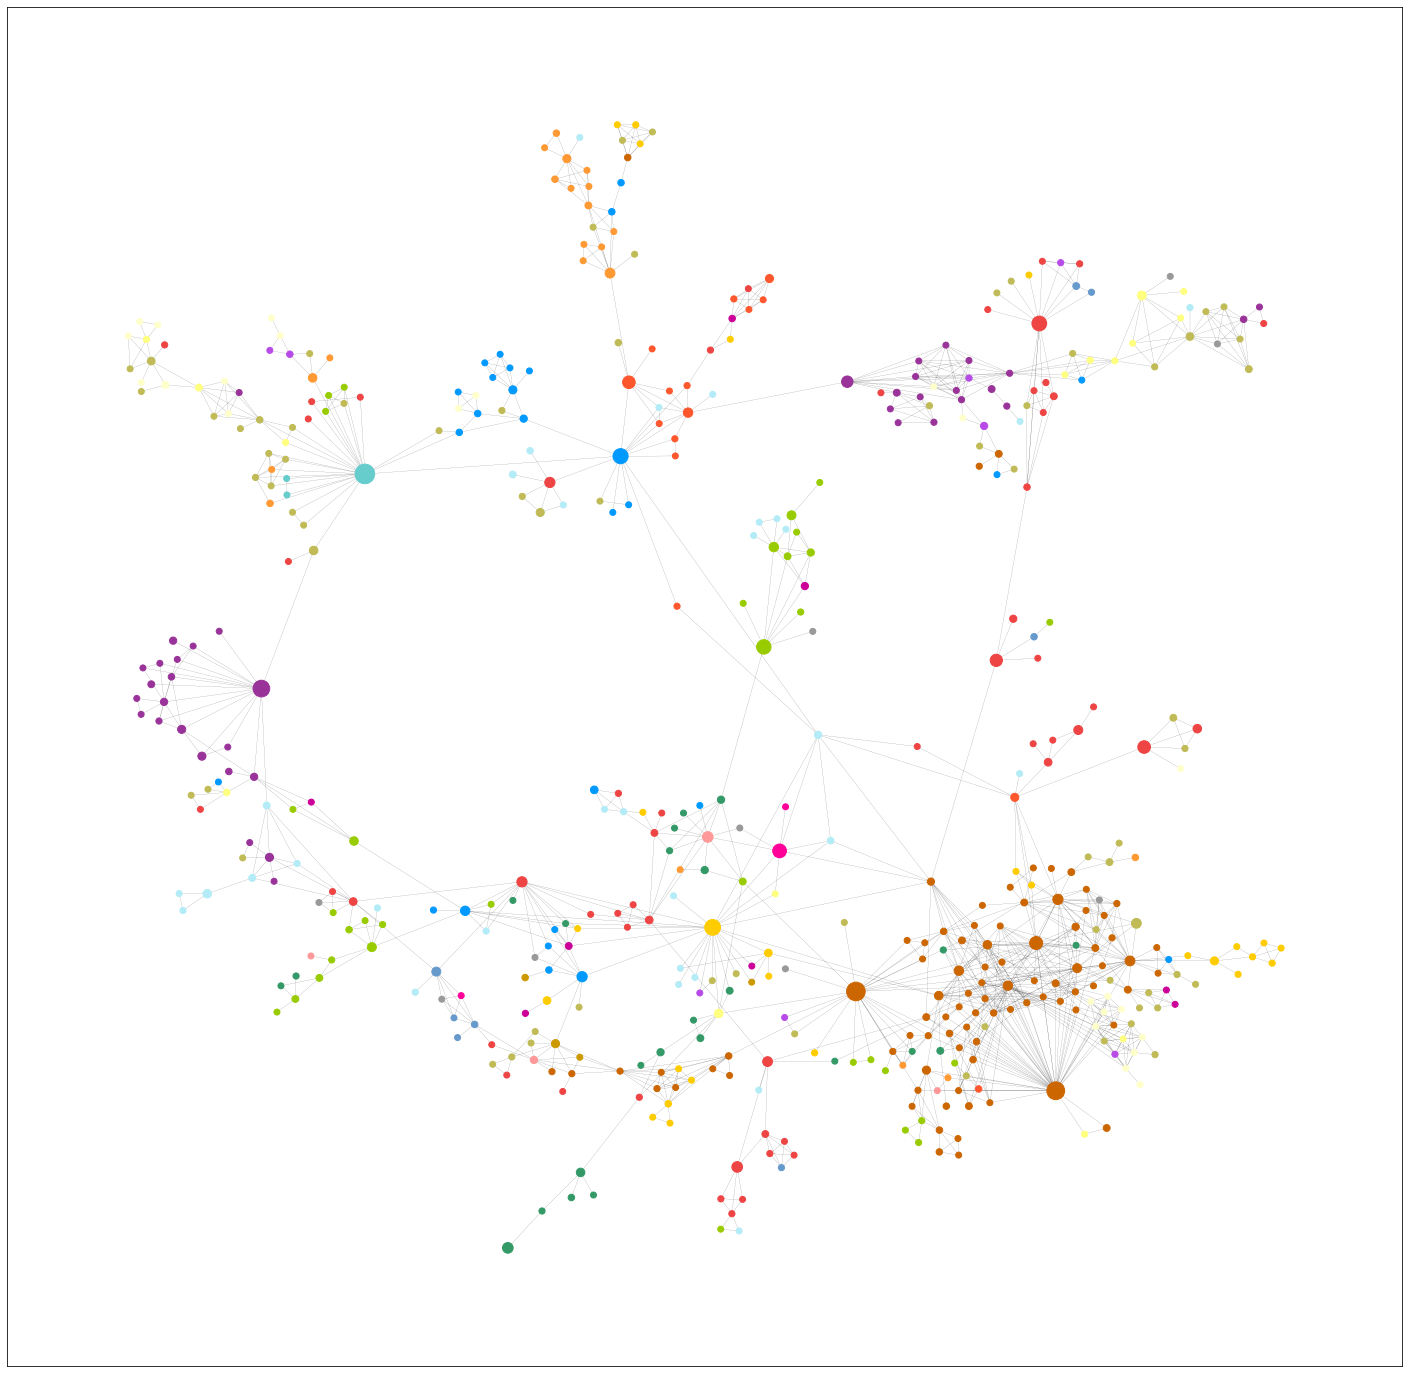

In [19]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=get_positions(pp), node_size=get_sizes(pp), with_labels=False, width=0.1)

In [20]:
new = create_subgraph_with_classes(pp, ['Ear,Nose,Throat','Neurological'])

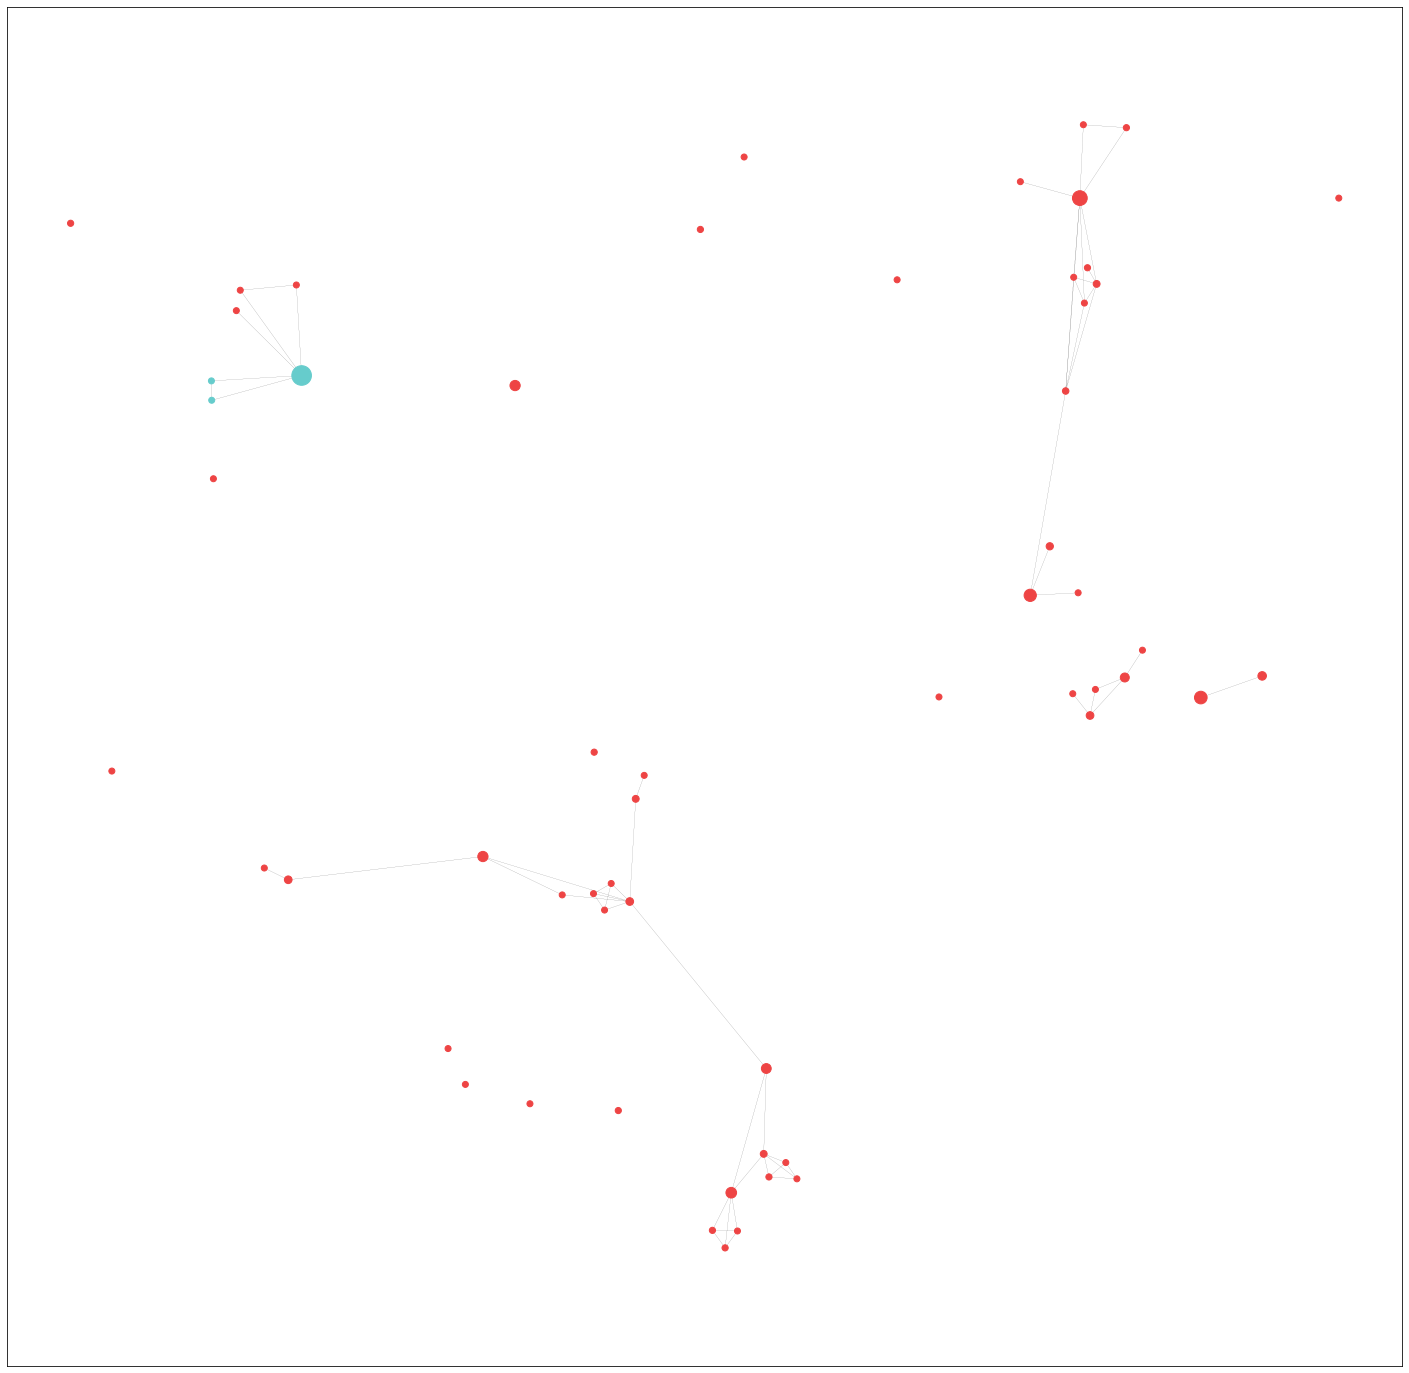

In [21]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(new, node_color=get_colours(new), pos=get_positions(new), node_size=get_sizes(new), with_labels=False, width=0.1)

In [22]:
encc = encoded_classes(pp)
nx.set_node_attributes(pp, list(encc.values())[0], list(encc.keys())[0])

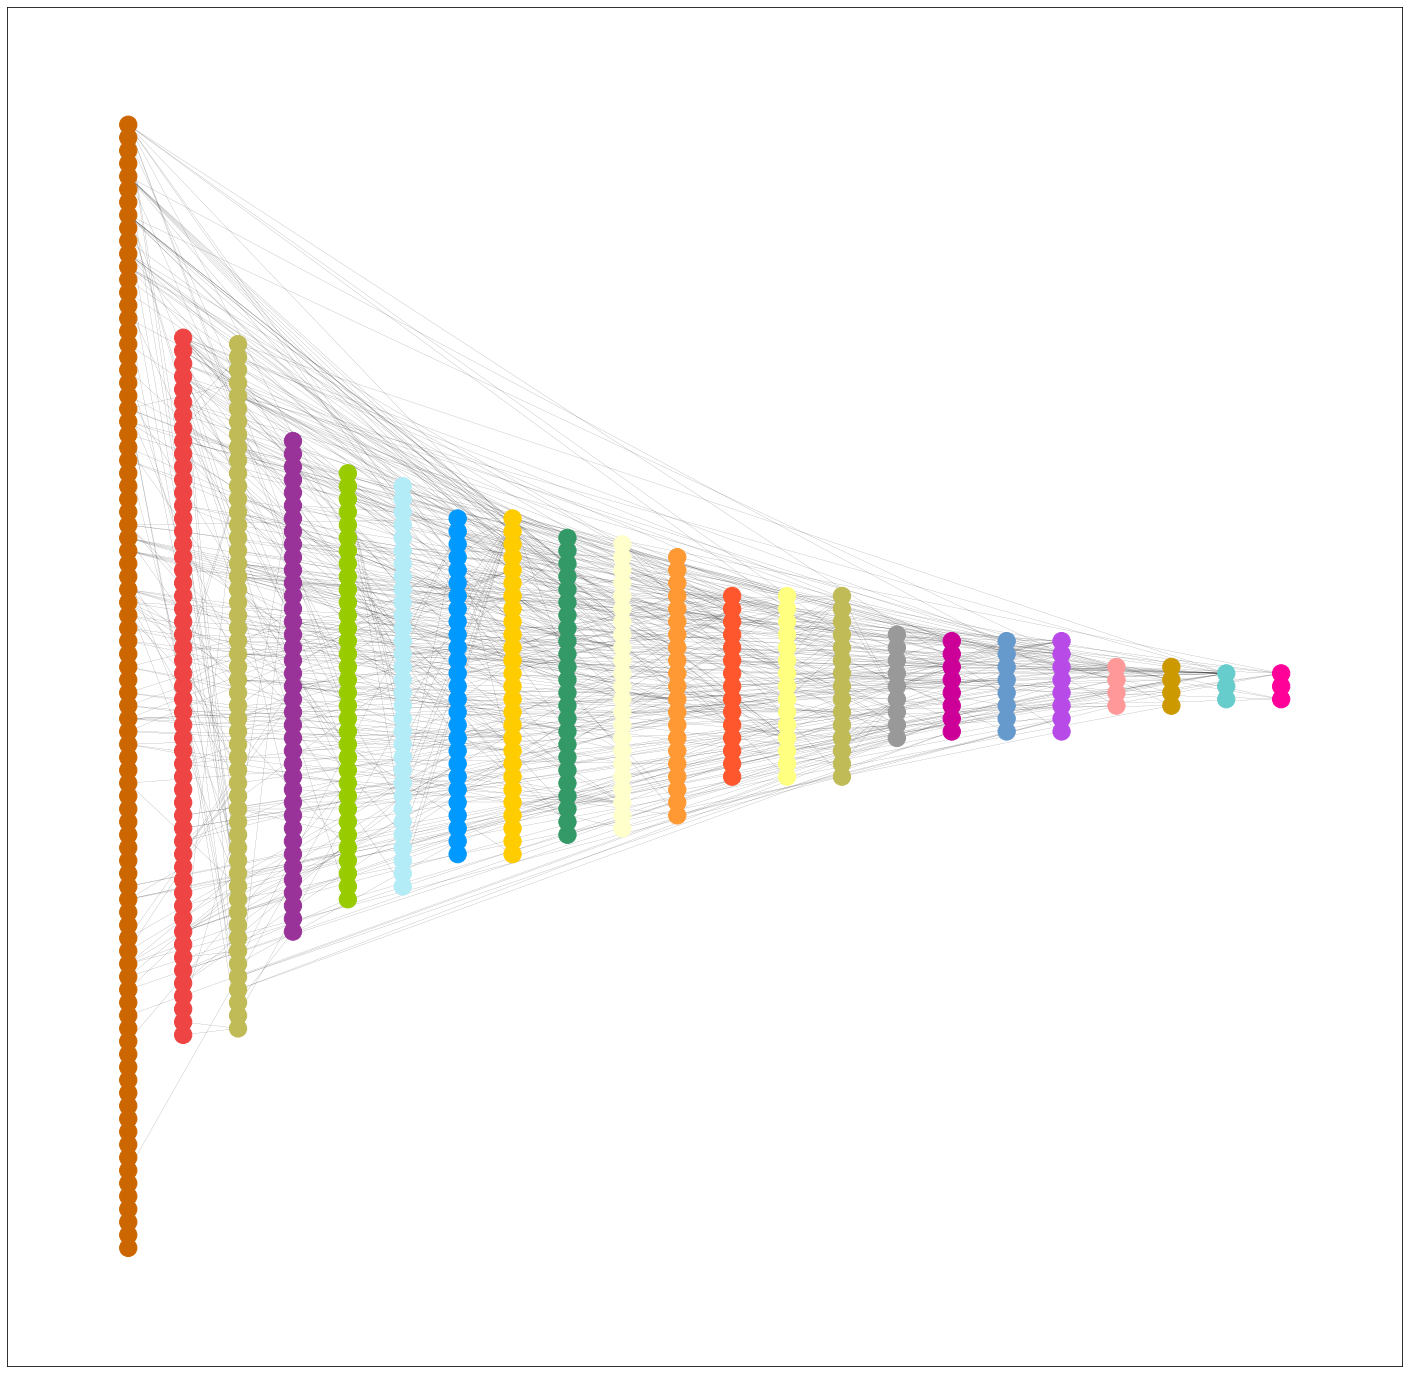

In [23]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=nx.drawing.multipartite_layout(pp, subset_key='encoded_class'), with_labels=False, width=0.1)

In [24]:
meta_comm = get_metadata_communities(pp)
densities = get_densities(pp, meta_comm, len(meta_comm))
_, sizes = get_sorted_freq(pp)
rnd = nx.stochastic_block_model(sizes, densities)

In [25]:
np.sum(np.diagonal(densities))

1.0

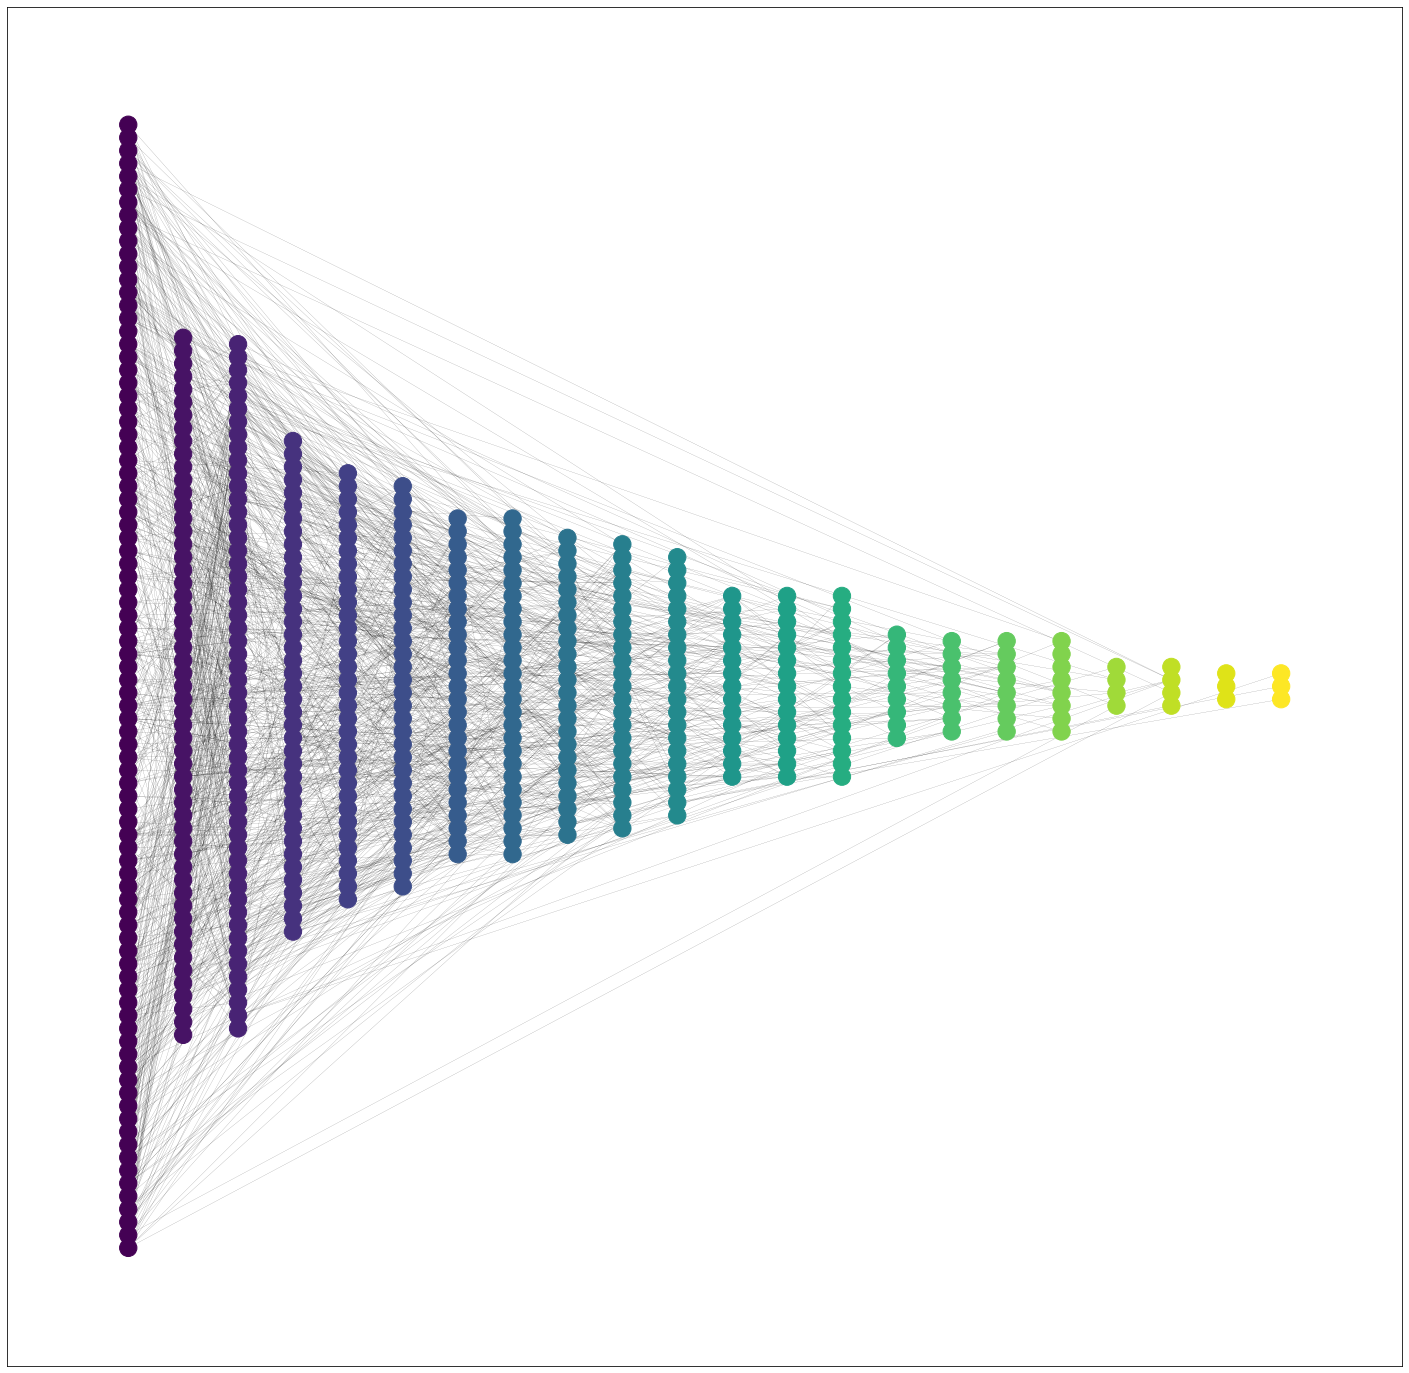

In [26]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(rnd, node_color=list(np.array(list(dict(rnd.nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(rnd, subset_key='block'), with_labels=False, width=0.1)